# `sum`: Recalling the performance lecture: an easy enough function to understand

The  **sum** function `sum(a)`, which computes

$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i.
$$

In [1]:
#Pkg.add("BenchmarkTools")
using BenchmarkTools

# 1a. serial Julia (as fast as handwritten c)

In [3]:
function jsum(A)   
    s = 0.  # s = zero(eltype(A))
    for a in A
        s += a
    end
    s
end

jsum (generic function with 1 method)

In [5]:
a = randn(10^7) # array of random numbers, uniform on [0,1)
j_bench = @benchmark jsum($a)
minimum(j_bench.times)/1e6

7.933992

## 1b. Built in Julia

In [6]:
sum_bench = @benchmark sum($a)
minimum(sum_bench.times)/1e6

4.42754

# 2a. Distributed Computing with DArrays (my favorite for the high level -- I wish it were more complete)

In [47]:
workers()

2-element Array{Int64,1}:
 2
 3

In [19]:
Pkg.add("DistributedArrays")
using DistributedArrays

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of DistributedArrays
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [48]:
A = distribute(a)  # one could have used A = drand(10^7) for a parallel constructor
A.indexes

2-element Array{Tuple{UnitRange{Int64}},1}:
 (1:5000000,)       
 (5000001:10000000,)

In [54]:
addprocs(1)

1-element Array{Int64,1}:
 8

In [55]:
workers() # 2 and 3 are workers  (so in parallel we have two processors)

5-element Array{Int64,1}:
 2
 3
 6
 7
 8

In [56]:
@everywhere using DistributedArrays
A = distribute(a)
A.indexes
A.pids

5-element Array{Int64,1}:
 2
 3
 6
 7
 8

In [37]:
sum(A)-sum(a)

-9.094947017729282e-13

In [57]:
minimum((@benchmark sum(erf,$A)).times)/1e6

46.829876

In [39]:
addprocs(1)

1-element Array{Int64,1}:
 5

In [40]:
workers()

4-element Array{Int64,1}:
 2
 3
 4
 5

In [41]:
@everywhere using DistributedArrays

In [42]:
A = distribute(a)  # one could have used A = drand(10^7) for a parallel constructor
sum(A) - sum(a)

0.0

In [43]:
A.indexes

4-element Array{Tuple{UnitRange{Int64}},1}:
 (1:2500000,)       
 (2500001:5000000,) 
 (5000001:7500000,) 
 (7500001:10000000,)

In [44]:
minimum((@benchmark sum($A)).times)/1e6

2.136494

In [21]:
#addprocs(1)
workers()

4-element Array{Int64,1}:
 2
 3
 4
 5

In [22]:
@everywhere using DistributedArrays

In [23]:
A = distribute(a)  # one could have used A = drand(10^7) for a parallel constructor
sum(A) - sum(a)

0.0

In [24]:
minimum((@benchmark sum($A)).times)/1e6

2.079622

In [38]:
@everywhere using DistributedArrays

In [39]:
A = distribute(a)  # one could have used A = drand(10^7) for a parallel constructor
sum(A) - sum(a)

0.0

In [40]:
minimum((@benchmark sum($A)).times)/1e6

4.166501

In [37]:
summary(A)

"10000000-element DistributedArrays.DArray{Float64,1,Array{Float64,1}}"

In [41]:
@which sum(A)

sum(d::DistributedArrays.DArray) at /Users/edelman/.julia/v0.5/DistributedArrays/src/mapreduce.jl:127

In [42]:
@which reduce(+,A)

reduce(f, d::DistributedArrays.DArray) at /Users/edelman/.julia/v0.5/DistributedArrays/src/mapreduce.jl:9

In [63]:
A = drand(100,100)

100×100 DistributedArrays.DArray{Float64,2,Array{Float64,2}}:
 0.27791   0.177413   0.711481   …  0.843845   0.0591269  0.272526 
 0.510093  0.182837   0.717953      0.352107   0.752599   0.711208 
 0.537597  0.47745    0.14142       0.255281   0.317744   0.554741 
 0.219325  0.831272   0.57554       0.0914628  0.487207   0.0531971
 0.534443  0.902926   0.671107      0.83575    0.0684562  0.0141652
 0.679946  0.304921   0.880249   …  0.180632   0.499286   0.574564 
 0.379231  0.62809    0.93864       0.55027    0.834998   0.958946 
 0.522919  0.13938    0.312957      0.213637   0.736627   0.327509 
 0.218729  0.435756   0.339414      0.0056295  0.220626   0.111073 
 0.949105  0.692698   0.239087      0.700097   0.866414   0.232658 
 0.805017  0.697718   0.9807     …  0.773541   0.610682   0.933739 
 0.184824  0.46412    0.372953      0.994141   0.0318437  0.618643 
 0.844153  0.183974   0.848029      0.247056   0.521273   0.445762 
 ⋮                               ⋱                    

In [107]:
@which reduce(+,r)

reduce(f, d::DistributedArrays.DArray) at /Users/alanedelman/.julia/v0.5/DistributedArrays/src/mapreduce.jl:9

## 2b. How do we implement DArray functionality?  Answer: Bootstrap from serial functionality.

In [25]:
#@everywhere using DistributedArrays
A = drand(10^7)

10000000-element DistributedArrays.DArray{Float64,1,Array{Float64,1}}:
 0.844815 
 0.0706291
 0.244676 
 0.257673 
 0.850414 
 0.738974 
 0.594129 
 0.585809 
 0.245183 
 0.249112 
 0.0265877
 0.180143 
 0.355788 
 ⋮        
 0.119152 
 0.687844 
 0.987118 
 0.0716491
 0.150896 
 0.29818  
 0.515473 
 0.661692 
 0.795226 
 0.931143 
 0.452085 
 0.175229 

In [5]:
a = convert( Array{Float64,1} , A)

10000000-element Array{Float64,1}:
 0.404224  
 0.697706  
 0.376151  
 0.238845  
 0.0161963 
 0.187521  
 0.951739  
 0.569651  
 0.607052  
 0.750241  
 0.00569606
 0.694259  
 0.213993  
 ⋮         
 0.64419   
 0.0347608 
 0.868681  
 0.360796  
 0.589133  
 0.00117402
 0.469419  
 0.933901  
 0.0584435 
 0.0569092 
 0.32551   
 0.67888   

In [108]:
# Simulated Parallel Algorithm
s = sum.([a[i[1]] for i in A.indexes]) 
display(s)
sum(s)

1×5 Array{Float64,2}:
 9.43521  9.43521  9.43521  9.43521  9.43521

47.176045364618474

In [33]:
# Actual Parallel Algorithm

In [109]:
for p in A.pids
    display(fetch(@spawnat p sum(localpart(A))))
end

1003.7170495398932

997.9600772256404

985.5766073717534

1009.2011500182504

1011.0772280407479

In [117]:
results = Float64[]
@sync for p in A.pids
     @async push!(results, fetch(@spawnat p sum(localpart(A))))
end

println(results)
sum(results)

[1009.2,1003.72,985.577,1011.08,997.96]


5007.532112196285

In [25]:
sum(a)

5.000864179629135e6

In [27]:
std(A)

0.288655919036807

In [28]:
mean(A)

0.5000864179629134

In [29]:
# What about a histogram?

In [35]:
Pkg.add("StatsBase")
using StatsBase

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of StatsBase
INFO: Use `Pkg.update()` to get the latest versions of your packages


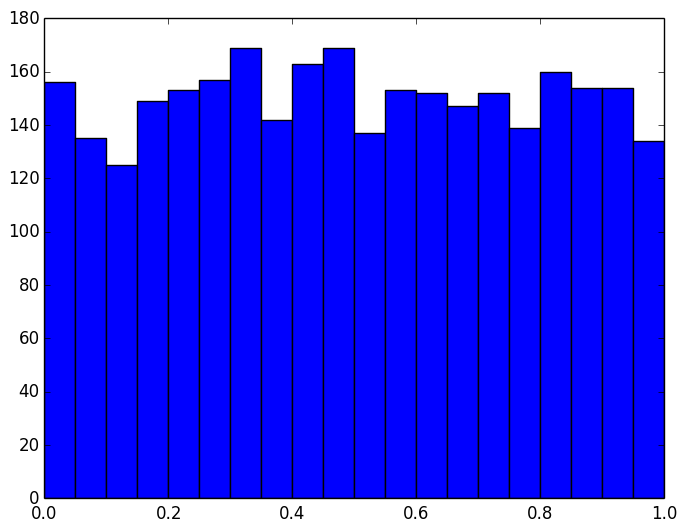

(PyObject <matplotlib.patches.Rectangle object at 0x328253050>,PyObject <matplotlib.patches.Rectangle object at 0x328253690>,PyObject <matplotlib.patches.Rectangle object at 0x328253d10>,PyObject <matplotlib.patches.Rectangle object at 0x3282603d0>,PyObject <matplotlib.patches.Rectangle object at 0x328260a50>,PyObject <matplotlib.patches.Rectangle object at 0x328260f50>,PyObject <matplotlib.patches.Rectangle object at 0x32826c790>,PyObject <matplotlib.patches.Rectangle object at 0x32826ce10>,PyObject <matplotlib.patches.Rectangle object at 0x3282784d0>,PyObject <matplotlib.patches.Rectangle object at 0x328278b50>,PyObject <matplotlib.patches.Rectangle object at 0x328286210>,PyObject <matplotlib.patches.Rectangle object at 0x328286890>,PyObject <matplotlib.patches.Rectangle object at 0x328286f10>,PyObject <matplotlib.patches.Rectangle object at 0x3282915d0>,PyObject <matplotlib.patches.Rectangle object at 0x328291c50>,PyObject <matplotlib.patches.Rectangle object at 0x32829e310>,PyObjec

In [67]:
w = fit(Histogram, rand(3000), 0:0.05:1.0).weights
bar(0:.05:.95,w,.05)

In [49]:
using PyPlot

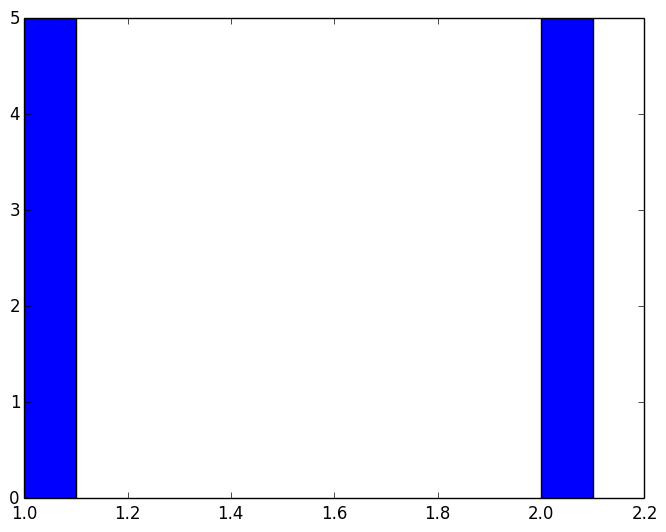

(PyObject <matplotlib.patches.Rectangle object at 0x32794fc10>,PyObject <matplotlib.patches.Rectangle object at 0x32795b290>)

In [75]:
A = drand(10^8)
@everywhere using StatsBase
@everywhere w1(x) = fit(Histogram,x,0:0.05:1.0).weights
results = Array{Int64,1}[]
@sync for p in A.pids
    @async push!(results, fetch(@spawnat p w1(localpart(A))))
end
sum(results)

20-element Array{Int64,1}:
 4999961
 4999755
 5000471
 4998540
 5000051
 4998667
 4999459
 4999721
 4996973
 4999831
 5002576
 5001157
 5001331
 4999327
 4999012
 4999832
 5003440
 5001896
 4998734
 4999266

In [69]:
nprocs()

5

## 3. @parallel  (looks like a "for loop", data starts and ends on master)

The history of Julia includes a "back and forth" between "for loop" notation and vectorized
notation.  The truth is, for some problems, one or the other, or both could be more natural,
or more performant, but not for the old reasons of dynamic languages where "for loops" were
always to be avoided.

In [121]:
 foo(a)=
@parallel (+) for aa in a
    aa # this could be a more complicated statistic
end

foo (generic function with 1 method)

In [123]:
a

10000000-element Array{Float64,1}:
  1.36558   
  0.00370977
 -0.758253  
 -0.314925  
 -0.931887  
 -0.466254  
 -1.46073   
  0.339821  
 -0.179909  
  0.723463  
 -0.43038   
 -1.39323   
  0.601403  
  ⋮         
  0.456856  
  0.160095  
  0.481282  
 -0.781246  
 -0.499679  
  1.86623   
 -0.40185   
 -0.895632  
  1.00465   
  0.77694   
  1.55936   
 -0.336109  

In [122]:
@benchmark foo($a)


BenchmarkTools.Trial: 
  memory estimate:  57.48 kb
  allocs estimate:  601
  --------------
  minimum time:     113.918 ms (0.00% GC)
  median time:      118.295 ms (0.00% GC)
  mean time:        118.600 ms (0.00% GC)
  maximum time:     137.104 ms (0.00% GC)
  --------------
  samples:          43
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [28]:
@everywhere randstat(n) = maximum(eigvals(SymTridiagonal(randn(n),randn(n-1))))

In [87]:
workers()

3-element Array{Int64,1}:
 2
 3
 4

In [29]:
@benchmark @parallel (+) for i in 1:250
    randstat(500) 
end

BenchmarkTools.Trial: 
  memory estimate:  45.47 kb
  allocs estimate:  580
  --------------
  minimum time:     414.461 ms (0.00% GC)
  median time:      416.580 ms (0.00% GC)
  mean time:        417.545 ms (0.00% GC)
  maximum time:     424.996 ms (0.00% GC)
  --------------
  samples:          12
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [30]:
@benchmark mapreduce(randstat,+,500*dones(Int,250))

BenchmarkTools.Trial: 
  memory estimate:  166.86 kb
  allocs estimate:  2491
  --------------
  minimum time:     414.413 ms (0.00% GC)
  median time:      417.328 ms (0.00% GC)
  mean time:        419.344 ms (0.00% GC)
  maximum time:     430.229 ms (0.00% GC)
  --------------
  samples:          12
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

## 4. MPI is possible for the die-hards and also some libraries

(See separate notebook)

## 5. Threads under development

In [7]:
function sim(n, seed = rand(UInt))
    nt = Threads.nthreads()
    ra = zeros(nt)
    Threads.@threads for i in 1:nt
        id   = Threads.threadid()
        rng  = MersenneTwister(id + seed)
        d, r = divrem(n, Threads.nthreads())
        bs = d + (r > 0)
        if id == nt
            bs = n - (nt - 1)*bs
        end
        ra[id] = sum(rand(rng, bs))
    end
    return sum(ra)
end

sim (generic function with 2 methods)

In [12]:
@benchmark sim(10^7)

BenchmarkTools.Trial: 
  memory estimate:  76.30 mb
  allocs estimate:  14
  --------------
  minimum time:     30.899 ms (24.22% GC)
  median time:      31.950 ms (23.90% GC)
  mean time:        32.455 ms (24.68% GC)
  maximum time:     76.777 ms (68.97% GC)
  --------------
  samples:          155
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [22]:
function sim2(a)
    nt = Threads.nthreads()
    return sum(a)
end

sim2 (generic function with 1 method)

In [23]:
a =  rand(10^7)
@benchmark sim2(a)

BenchmarkTools.Trial: 
  memory estimate:  16.00 bytes
  allocs estimate:  1
  --------------
  minimum time:     4.637 ms (0.00% GC)
  median time:      4.922 ms (0.00% GC)
  mean time:        5.010 ms (0.00% GC)
  maximum time:     6.658 ms (0.00% GC)
  --------------
  samples:          997
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [19]:
workers()

1-element Array{Int64,1}:
 1

## 6.  GPU Libraries using ArrayFire

Step 1. Follow directions in https://github.com/JuliaComputing/ArrayFire.jl from a terminal to load arrayfire on your machine.